In [1]:
import sys; sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

LOADING DATA FROM KAGGLE

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 99% 98.0M/98.7M [00:05<00:00, 18.3MB/s]
100% 98.7M/98.7M [00:05<00:00, 19.0MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/melanoma-skin-cancer-dataset-of-10000-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [6]:
train_path = '/content/melanoma_cancer_dataset/train'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

Found 9605 files belonging to 2 classes.


In [7]:
test_path = '/content/melanoma_cancer_dataset/test'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 1000 files belonging to 2 classes.


DATASET SPLITTING

In [8]:
DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

240 61


DATASET VISUALIZATION

In [9]:
import matplotlib.pyplot as plt

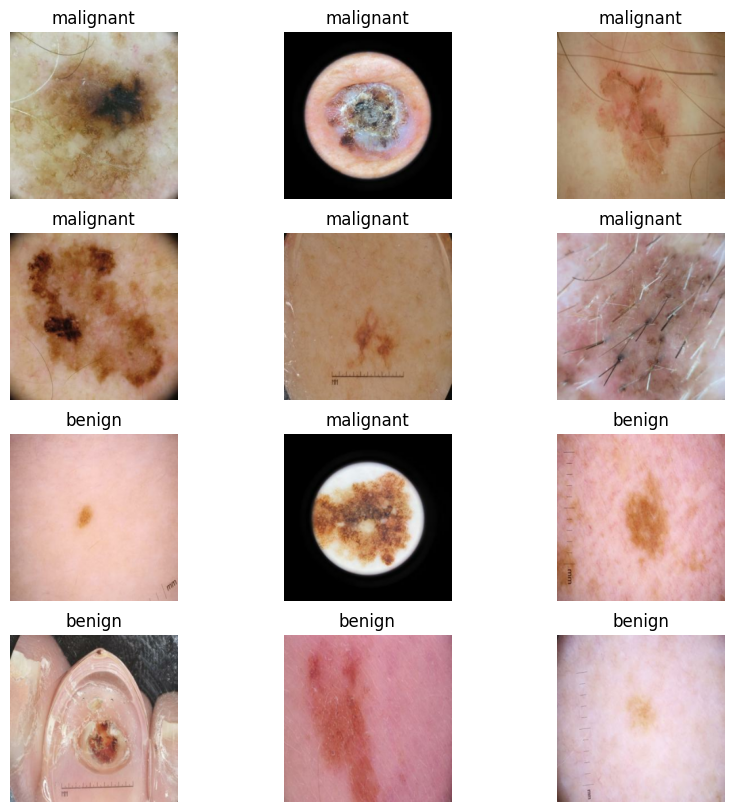

In [10]:
class_names = ds.class_names
plt.figure(figsize= (10,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis('off')

MODEL BUILDING

In [11]:
from keras.layers import RandomFlip, RandomRotation

In [12]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [13]:
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label
train, val, test = train.map(Normalizer), val.map(Normalizer), test.map(Normalizer)

In [14]:
model = Sequential([
    Augmentation,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32, 256, 256, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=2, activation="Softmax"),
])
model.build (input_shape=(32, 256, 256, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 32)         

In [15]:
model.compile(
    optimizer= 'adam',
    loss=  'sparse_categorical_crossentropy',
    metrics = ['accuracy',]
)

In [16]:
from keras.callbacks import EarlyStopping

In [17]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True,
)

MODEL TRAINING

In [18]:
history = model.fit(train, batch_size= 32, epochs=25, verbose=1, validation_data=val, callbacks=[early_stopping])

Epoch 1/25
240/240 [==============================] - 32s 100ms/step - loss: 0.4781 - accuracy: 0.7525 - val_loss: 0.3333 - val_accuracy: 0.8561
Epoch 2/25
240/240 [==============================] - 26s 106ms/step - loss: 0.3472 - accuracy: 0.8548 - val_loss: 0.3424 - val_accuracy: 0.8675
Epoch 3/25
240/240 [==============================] - 25s 105ms/step - loss: 0.3237 - accuracy: 0.8664 - val_loss: 0.3308 - val_accuracy: 0.8655
Epoch 4/25
240/240 [==============================] - 23s 95ms/step - loss: 0.3307 - accuracy: 0.8613 - val_loss: 0.3320 - val_accuracy: 0.8540
Epoch 5/25
240/240 [==============================] - 24s 99ms/step - loss: 0.3117 - accuracy: 0.8671 - val_loss: 0.2999 - val_accuracy: 0.8675
Epoch 6/25
240/240 [==============================] - 23s 93ms/step - loss: 0.2928 - accuracy: 0.8767 - val_loss: 0.2854 - val_accuracy: 0.8681
Epoch 7/25
240/240 [==============================] - 24s 97ms/step - loss: 0.2935 - accuracy: 0.8751 - val_loss: 0.3081 - val_accura

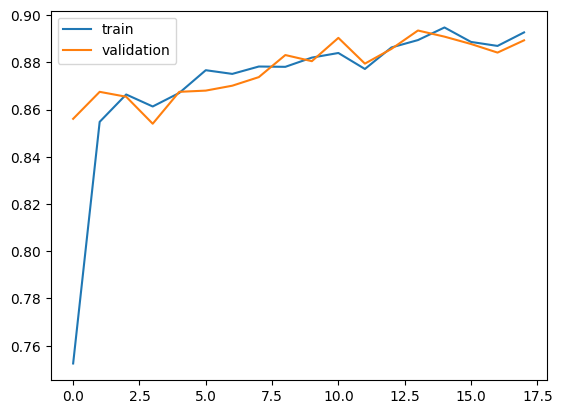

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

MODEL EVALUATION

In [20]:
loss, accuracy = model.evaluate(test); print(loss, accuracy)

32/32 [==============================] - 2s 54ms/step - loss: 0.2432 - accuracy: 0.8990
0.24315443634986877 0.8989999890327454


Actual Label:  benign
1/1 [==============================] - 0s 265ms/step
Predicted Label:  benign


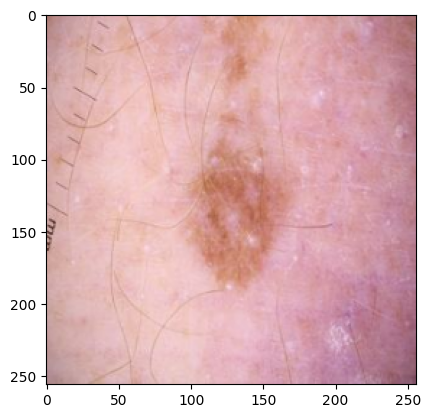

In [21]:
for images, label in test.take(1):
  img = (images[0]*255).numpy().astype('uint8')
  plt.imshow(img)
  print('Actual Label: ', class_names[label[0].numpy()])
  pred = model.predict(images)
  print('Predicted Label: ', class_names[np.argmax(pred[0])])

In [28]:
model.save('modelv1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
